In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import openai
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set your OpenAI API key
openai.api_key = ''

In [3]:
# Step 1: Load the dataset
file_path = '3026NMfixed_UT.csv'
dataset = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the dataset
print(dataset.head())

   no Speaker                                          utterance  ut
0   1       T  Ok. So you’re going to be talking about - we’r...   Q
1   2       T  You all should probably be able to tell me tha...   P
2   3       S                                         Nope. No.   Ry
3   4       T     You don’t? Don’t you all ride the school bus?    Q
4   5       S                                          Yes. No.   Ry


In [5]:
# Function to get GPT-3 embeddings for a given text
def get_gpt3_embeddings(text_list):
    embeddings = []
    for text in text_list:
        response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
        embeddings.append(response['data'][0]['embedding'])
    return np.array(embeddings)

In [6]:
# Get GPT-3 embeddings for the 'utterance' column
X_text = get_gpt3_embeddings(dataset['utterance'].tolist())

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

In [ ]:
# Step 3: Dimensionality Reduction (Optional but can help with noise)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_text)

In [8]:
# Step 4: Function to evaluate clustering configuration using silhouette score
def evaluate_clustering(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    return score

In [9]:
# Improved Randomized Hill Climbing to find the best number of clusters
def randomized_hill_climbing(data, max_clusters=20, iterations=200, restarts=5):
    best_score = -1
    best_k = 2

    for _ in range(restarts):
        current_k = np.random.randint(2, max_clusters + 1)
        
        for i in range(iterations):
            current_score = evaluate_clustering(current_k, data)
            
            if current_score > best_score:
                best_score = current_score
                best_k = current_k
            
            # Randomly pick a new k
            next_k = np.random.randint(2, max_clusters + 1)
            current_k = next_k
    
    return best_k, best_score

In [10]:
# Find the optimal number of clusters with increased range and restarts
optimal_k, optimal_score = randomized_hill_climbing(X_reduced, max_clusters=30, iterations=300, restarts=10)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {optimal_score}")

Optimal number of clusters: 29
Best silhouette score: 0.15256682326616108


In [11]:
# Perform final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(X_reduced)

In [12]:
# Display the cluster labels for the first few utterances
dataset['Cluster'] = final_labels
print(dataset.head())

   Speaker                       utterance  ut  Cluster
0        2                      Nope. No.   10       20
1        2                       Yes. No.   10       20
2        2                          Yeah.   10       19
3        2                      Movement.    9        5
4        2  Distance traveling over time.    9        0


In [13]:
# Step 5: Visualize the clusters using t-SNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

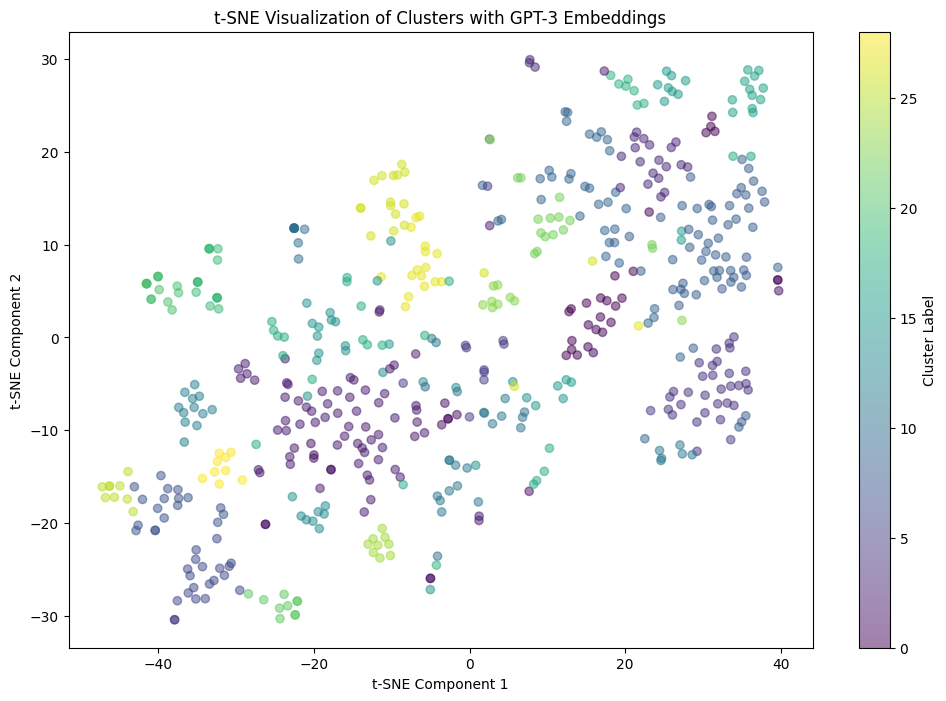

In [14]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters with GPT-3 Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

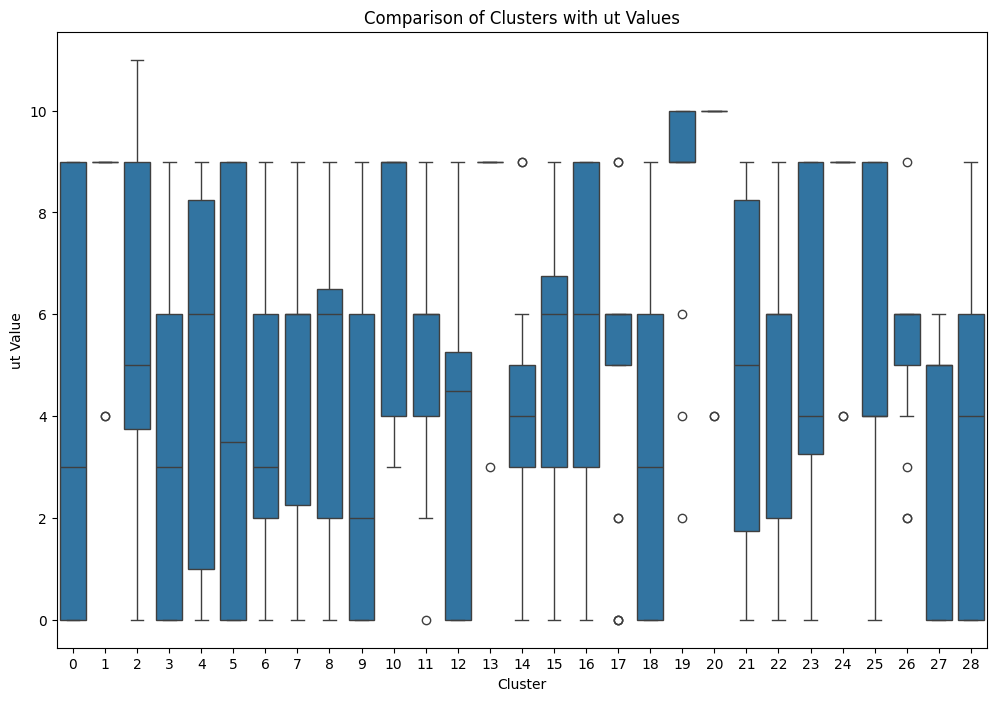

In [15]:
# Step 6: Compare Clusters with 'ut' Values

# Box plot to visualize the distribution of 'ut' values across clusters
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='ut', data=dataset)
plt.title('Comparison of Clusters with ut Values')
plt.xlabel('Cluster')
plt.ylabel('ut Value')
plt.show()

In [16]:
# Statistical summary of 'ut' values in each cluster
cluster_summary = dataset.groupby('Cluster')['ut'].describe()
print(cluster_summary)

         count      mean       std  min    25%   50%    75%   max
Cluster                                                          
0         25.0  3.960000  3.690980  0.0   0.00   3.0   9.00   9.0
1         18.0  8.444444  1.616904  4.0   9.00   9.0   9.00   9.0
2         68.0  5.573529  2.938759  0.0   3.75   5.0   9.00  11.0
3         22.0  3.181818  2.938032  0.0   0.00   3.0   6.00   9.0
4         30.0  4.766667  3.480818  0.0   1.00   6.0   8.25   9.0
5         14.0  4.000000  4.132423  0.0   0.00   3.5   9.00   9.0
6         18.0  3.666667  2.970443  0.0   2.00   3.0   6.00   9.0
7         18.0  4.500000  3.148296  0.0   2.25   6.0   6.00   9.0
8         55.0  4.872727  3.237824  0.0   2.00   6.0   6.50   9.0
9         37.0  2.972973  3.287066  0.0   0.00   2.0   6.00   9.0
10         9.0  6.666667  2.783882  3.0   4.00   9.0   9.00   9.0
11        27.0  5.333333  1.941451  0.0   4.00   6.0   6.00   9.0
12        12.0  3.583333  2.998737  0.0   0.00   4.5   5.25   9.0
13        